Код самой Fuzzy_Artmap со всеми необходимыми функциями

In [2]:
import numpy as np
import random

class Fuzzy_Artmap():
    def __init__(self, M = 625, choice = 0.001, learn = 0.5, vig = 0.75, st_vig = 0.75, eps = 0.001):
        #size of F-level
        self.M = M 
        #choice parameter
        self.choice=choice
        #learning parameter 
        self.learn=learn
        #changable vigilance parameter
        self.vig=vig
        #stable vigilance parameter
        self.st_vig=st_vig
        #matching parameter
        self.eps=eps
        #weights from F to C
        self.C=np.array([])
        #weights from I to F
        self.W=np.array([])
        #original data answers
        self.orig_result =np.array([])

    #complete our input
    def make_input(self, I):
        return np.concatenate((I,np.ones(I.shape) - I),axis=1)
    
    #func to calculate a^b
    def min_array(self,a,b):
        return np.array([min(a[i],b[i]) for i in range(len(a))])
    
    #func with which we select the optimal F-level vertex for our input
    def choice_function(self,x,w):
        T = sum(self.min_array(x,w))/(self.choice + sum(w))
        return T
    

    def train(self,I, I_res):
        self.M = len(I[0])
        self.orig_result=I_res
        self.C = [0]
        self.W = np.ones((1,self.M*2))
        I = self.make_input(I)
           
        for index, a_i in enumerate(I):
            #just to see how fast training goes
            if index%1000==0:
                print(index)

            if index==0:
                self.W[0]=a_i
                self.C[0]=self.orig_result[0];
                continue

            T_list=np.array([self.choice_function(a_i, w_i) for w_i in self.W])
            T_max = np.argmax(T_list)
            while 1:
                #if no good F-vertex found, build a new one
                if sum(T_list)==0:
                    #if self.W.shape[0]<400:
                    self.C = np.concatenate((self.C,[self.orig_result[index]]))
                    self.W = np.concatenate((self.W,[a_i]),axis=0)
                    #else:
                    #    self.C[T_max] = self.orig_result[index]
                    break

                #best matching F-vertex
                J = np.argmax(T_list)
                res = sum(self.min_array(a_i,self.W[J]))/self.M 
                if res >= self.vig:
                    if self.orig_result[index]==self.C[J]:
                        #making new weights
                        self.W[J] = self.learn*(self.min_array(a_i,self.W[J])) + (1-self.learn)*(self.W[J])
                        break
                    else:
                        T_list[J] = 0
                        #making better vig, as we failed
                        self.vig = sum(self.min_array(a_i,self.W[J]))/self.M + self.eps
                else:
                    T_list[J] = 0
            self.vig=self.st_vig

    def predict(self, input_i):
        I =self.make_input(input_i)
        sum_reson = 0
        ans = []
        for I_i in I:
            T_list=np.array([self.choice_function(I_i, w_i) for w_i in self.W])
            while 1:
                if sum(T_list)==0:
                    ans.append(-1)
                    break;
                J = np.argmax(T_list)
                resonance = sum(self.min_array(I_i,self.W[J]))/self.M
                sum_reson += resonance
                if resonance >= self.vig:
                    ans.append(self.C[J])
                    break
                else:
                    T_list[J]=0
        return ans, sum_reson

Проверим на простых примерах, что код работает правильно.\
Во всех примерах мы, обучившись, будем считать сколько из 1000 тестов нейронная сеть будет выдавать правильный/неправильный ответ, либо говорить, что не может найти точный ответ.

1. На вход подается число Х. Нейронная сеть получаем в качестве входных данных [X%2, X%3, X%5] и должна научиться определять X%30.\
Если все сделано правильно, то из-за небольшого множества возможных входных данных, сеть должна обучиться отвечать на любой вопрос правильно.

In [3]:
A = Fuzzy_Artmap()
testing_data = np.array([[(i%2)/2, (i%3)/3, (i%5)/5] for i in range(10001)])
testing_answers = np.array([i % 30 for i in range(10001)])
A.train(testing_data, testing_answers)
test = np.array([random.randint(1,10000) for i in range(1000)])
test_predict = np.array([[(i%2)/2, (i%3)/3, (i%5)/5] for i in test])
res, sum_reson = A.predict(test_predict)
good, bad, undef = 0,0,0
for i in range(1000):
    if res[i] == -1:
        undef += 1
    else:
        if test[i] % 30 == res[i]:
            good += 1
        else:
            bad += 1
print("good:", good, "bad:", bad, "undef:", undef, "avg_reson:", sum_reson/1000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
good: 1000 bad: 0 undef: 0 avg_reson: 1.0


Числа k*1000 - количество sampl-ов, на которых сеть уже обучилась. Удобно, чтобы понимать скорость обучения.
Как мы можем видеть, все считается правильно.

2. На вход подается число Х. Нейронная сеть получаем в качестве входных данных [X%2, X%3, X%5, X%7, X] и должна научиться определять X%30.\
Здесь вариантов входных данных уже больше, появилось два параметра, от которых, грубо говоря, ничего не зависит. Мы хотим проверить, не испортят ли они наше обучение.

In [5]:
B = Fuzzy_Artmap()
testing_data = np.array([[(i%2)/2, (i%3)/3, (i%5)/5, (i%7)/7, i/10001] for i in range(10001)])
testing_answers = np.array([i % 30 for i in range(10001)])
B.train(testing_data, testing_answers)
test = np.array([random.randint(1,10000) for i in range(1000)])
test_predict = np.array([[(i%2)/2, (i%3)/3, (i%5)/5, (i%7)/7, i/10001] for i in test])
res, sum_reson = B.predict(test_predict)
good, bad, undef = 0,0,0
for i in range(1000):
    if res[i] == -1:
        undef += 1
    else:
        if test[i] % 30 == res[i]:
            good += 1
        else:
            bad += 1
print("good:", good, "bad:", bad, "undef:", undef, "avg_reson:", sum_reson/1000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
good: 1000 bad: 0 undef: 0 avg_reson: 0.770884990114715


Как мы видим, все еще 100 процентов тестов решились правильно, хотя средний параметр бдительности стал порядка 0.75. То есть в каждом результате мы "уверены" в среднем на 77 процентов, но этого оказывается достаточно.

3. На вход поступает массив из 5 элементов от 1 до 10. Мы хотим, чтобы нейросеть обучилась находить максимальный элемент массива. \
Здесь уже пространство различных входных данных огромное - 10^5 вариантов, все их мы явно не запомним. Более того, немного отличающиеся данные могут давать отличающиеся ответы. Поэтому мы рассчитываем просто на хороший процент правильный ответов.

In [33]:
C = Fuzzy_Artmap()
testing_data = np.array([[random.randint(1, 10)/10 for i in range(5)] for i in range(5001)])
testing_answers = np.array([np.argmax(testing_data[i]) for i in range(5001  )])
C.train(testing_data, testing_answers)
test_predict = np.array([[random.randint(1, 10)/10 for i in range(5)] for i in range(1000)])
res, sum_reson = C.predict(test_predict)
good, bad, undef = 0,0,0
for i in range(1000):
    if res[i] == -1:
        undef += 1
    else:
        for j in range(5):
            if test_predict[i][j] > test_predict[i][res[i]]:
                bad += 1
                break
        else:
            good += 1
print("good:", good, "bad:", bad, "undef:", undef)

0
1000
2000
3000
4000
5000
good: 913 bad: 87 undef: 0


Получили в итоге примерно 90% процентов правильных ответов. Очень неплохо, все работает. Если увеличивать размер обучаемой выборки, то у меня доходило до 95 процентов, но там уже обучение происходит слишком долго.

Можно переходить к непосредственному применению нейронной сети для моей задачи.\
На сайте http://sigma.whu.edu.cn/newspage.php?q=2019_03_26_ENG я нашел датасет, который включает себя изображения ровно для проверки change detectiton алгоритмов.\
Сначала распарсим train data.\
Изначально она хранится в папках first и second в виде .tif изображений и класс картинки указан непосредственно в ее названии.

(150, 150, 4)


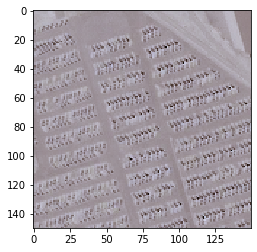

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.image import imread
%matplotlib inline
import os
A = imread('first/l1_n1_x2987_y3748.tif')
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Изображения из датасета хранятся в виде картинок $150\times150$, каждая прнадлежит какому-то классу.\
Каждое изображение я разделил на 36 изображений $25\times25$, усреднил значение в каждом квадрате $5\times5$ и добавил получившиеся данные в соответствующий класс.

In [10]:
data = [[] for i in range(8)]
for root, dirs, files in os.walk("./first"):
    for filename in files:
        cl = int(str(filename)[1]) - 1
        A = imread("first/" + str(filename))
        for i in range(6):
            for j in range(6):
                curA = A[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
                resA = np.zeros((5,5,3))
                for x in range(5):
                    for y in range(5):
                        for ix in range(5*x, 5*(x+1)):
                            for iy in range(5*y, 5*(y+1)):
                                resA[x][y] +=curA[ix][iy]
                resA /= (25*256)
                data[cl].append(resA)
for root, dirs, files in os.walk("./second"):
    for filename in files:
        cl = int(str(filename)[1]) - 1
        A = imread("second/" + str(filename))
        for i in range(6):
            for j in range(6):
                curA = A[25*i:25*(i+1), 25*j:25*(j+1)][:,:,:-1]
                resA = np.zeros((5,5,3))
                for x in range(5):
                    for y in range(5):
                        for ix in range(5*x, 5*(x+1)):
                            for iy in range(5*y, 5*(y+1)):
                                resA[x][y] +=curA[ix][iy]
                resA /= (25 * 256)
                data[cl].append(resA)

Для каждого класса я получил вот столько картинок $5\times5$ для обучения.

In [11]:
print([len(data[i]) for i in range(8)])
print(sum([len(data[i]) for i in range(8)]))

[720, 2052, 936, 1836, 2016, 1908, 1800, 2412]
13680


Теперь переделаем изображения в простой numpy array и добавим информацию о принадлежащем классе.

In [12]:
resulted_data = np.zeros((13680, 76))
s=0
for cl in range(8):
    for j in data[cl]:
        resulted_data[s][:-1] = np.reshape(j, (75, ))
        resulted_data[s][-1] = cl
        s+=1
print(resulted_data)

[[0.698125   0.68015625 0.71234375 ... 0.59015625 0.625      0.        ]
 [0.6696875  0.64453125 0.67046875 ... 0.615625   0.6553125  0.        ]
 [0.61953125 0.58046875 0.61296875 ... 0.5603125  0.58296875 0.        ]
 ...
 [0.4934375  0.41984375 0.4828125  ... 0.22078125 0.26046875 7.        ]
 [0.34       0.25703125 0.29171875 ... 0.37078125 0.40625    7.        ]
 [0.44453125 0.36390625 0.39671875 ... 0.41828125 0.4609375  7.        ]]


Ну и еще перемешаем, чтобы обучаться не подряд по классам, и разделить ответы от входных данных

In [19]:
np.random.shuffle(resulted_data)
final_data = resulted_data[:,:-1]
final_data_answers = resulted_data[:, -1]
print(final_data)
print(final_data_answers)

[[0.250625   0.23328125 0.273125   ... 0.2890625  0.26234375 0.3034375 ]
 [0.125625   0.153125   0.22421875 ... 0.30609375 0.27859375 0.31953125]
 [0.42109375 0.3453125  0.40015625 ... 0.49765625 0.44203125 0.5065625 ]
 ...
 [0.2928125  0.19046875 0.2815625  ... 0.5003125  0.44140625 0.5515625 ]
 [0.2009375  0.18203125 0.22984375 ... 0.38578125 0.359375   0.44359375]
 [0.175      0.08828125 0.53921875 ... 0.165      0.10546875 0.5375    ]]
[6. 7. 4. ... 7. 5. 1.]


Выгружаем полученные данные на комп.

In [20]:
with open('test_data.npy', 'wb') as f:
    np.save(f, final_data)
with open('test_data_answers.npy', 'wb') as f:
    np.save(f, final_data_answers)

Распарсив train data, попробуем обучиться на ней.

In [40]:
A = Fuzzy_Artmap()
testing_data = np.load("./test_data.npy")
testing_answers = np.load("./test_data_answers.npy")
print(testing_data.shape, testing_answers.shape)
print(testing_data.shape)
A.train(testing_data[:10000], testing_answers[:10000])

(13680, 75) (13680,)
(13680, 75)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


Проверим теперь, что все работает примерно правильно.

In [44]:
test_predict = testing_data[10000:11000]
res, sum_reson = A.predict(test_predict)
good, bad, undef = 0,0,0
match_array = np.zeros((8,8))
for i in range(1000):
    if res[i] == -1:
        undef += 1
    else:
        match_array[int(testing_answers[10000+i])][int(res[i])]+=1
        if testing_answers[10000+i] == res[i]:
            good += 1
        else:
            bad += 1
print("good:", good, "bad:", bad, "undef:", undef)
print(match_array)

good: 493 bad: 507 undef: 0
[[ 11.   0.   1.  15.   7.   0.   0.  18.]
 [  0. 148.   2.   1.   4.   1.   0.   3.]
 [  1.   0.  22.  16.  10.   0.   6.  12.]
 [ 11.   0.   6.  69.  31.   1.   4.  18.]
 [  5.   0.   9.  34.  54.   3.   6.  29.]
 [  3.   0.   6.   5.  14.  61.  21.  24.]
 [  1.   0.  14.   4.  14.  17.  58.  28.]
 [  8.   1.   6.  20.  37.  14.  16.  70.]]


Получилось довольно мало, но хоть какая-то точность есть. Мы однозначно видим, что нейронная сеть классифицирует картинки не каким-то случайным образом.\
Во многом, думаю, это происходит из-за того, что поделив картинку на 36 частей, у меня многие из частей на самом деле не относятся к тому классу, к которому относилась вся картинка. Но эти издержки нам необходимы, чтобы размер датасета был не очень маленьким, а входные данные не такие огромные и информативные.